## Import packages

In [3]:
import pandas as pd
import geojson as gsn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import spatial analysis packages
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point
import geoplot.crs as gcrs
import geoplot as gplt
import pyproj
from shapely.geometry import Polygon


## Ground Measures Data

### Load Ground Measure data

Ground measure data provides us with the measure snow water equivalent (SWE) at SNOTEC and CDEC sites across western U.S.

In [4]:
gm_md = pd.read_csv("../data/ground_measures_metadata.csv")
gm_md = gpd.GeoDataFrame(gm_md, geometry=gpd.points_from_xy(gm_md.longitude, gm_md.latitude))
gm_md

,station_id,name,elevation_m,latitude,longitude,state,geometry
0,CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,POINT (-120.79200 41.23700)
1,CDEC:AGP,Agnew Pass,2880.360000,37.726631,-119.141731,California,POINT (-119.14173 37.72663)
2,CDEC:ALP,Alpha (Smud),2316.480000,38.804192,-120.215652,California,POINT (-120.21565 38.80419)
3,CDEC:BCB,Blackcap Basin,3139.440000,37.066685,-118.773010,California,POINT (-118.77301 37.06668)
4,CDEC:BCH,Beach Meadows,2331.720000,36.126095,-118.293457,California,POINT (-118.29346 36.12609)
...,...,...,...,...,...,...,...
759,SNOTEL:994_WA_SNTL,Epa Quinault Open,91.440002,46.483330,-123.966667,Washington,POINT (-123.96667 46.48333)
760,SNOTEL:995_WA_SNTL,Epa Quinault Can,91.440002,46.483330,-123.966667,Washington,POINT (-123.96667 46.48333)
761,SNOTEL:996_WA_SNTL,NWA Heather Mdws,1267.968018,48.849998,-121.666672,Washington,POINT (-121.66667 48.85000)
762,SNOTEL:998_WA_SNTL,Easy Pass,1606.296021,48.859329,-121.438950,Washington,POINT (-121.43895 48.85933)


In [5]:
gm_md.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   station_id   764 non-null    object  
 1   name         764 non-null    object  
 2   elevation_m  764 non-null    float64 
 3   latitude     764 non-null    float64 
 4   longitude    764 non-null    float64 
 5   state        764 non-null    object  
 6   geometry     764 non-null    geometry
dtypes: float64(3), geometry(1), object(3)
memory usage: 41.9+ KB


## Cell grids


### Load cell grid data

This [dataset]("../data/grid_cells.geojson") provides us spatial information about the grid cells that we're modelling for.

In [6]:
path = "../data/grid_cells.geojson"
with open(path) as f:
    gj = gsn.load(f)
print(len(gj['features']))
# gj['features']

18130


In [7]:
gj.keys()

dict_keys(['type', 'crs', 'features'])

In [8]:
gj['features'][1]

{"geometry": {"coordinates": [[[-107.076787, 37.780424], [-107.076787, 37.787523], [-107.08577, 37.787523], [-107.08577, 37.780424], [-107.076787, 37.780424]]], "type": "Polygon"}, "properties": {"cell_id": "000617d8-8c14-43e2-b708-7e3a69fe3cc3", "region": "central rockies"}, "type": "Feature"}

Let's transform our geojson data into a dataframe so its easier to look at and work with

In [9]:
grid_cell_df = pd.DataFrame.from_dict(gj['features'])
grid_cell_df['cell_id'] = [x['cell_id'] for x in grid_cell_df['properties']]
grid_cell_df['coordinates'] = [x['coordinates'][0][0:] for x in grid_cell_df['geometry']]
grid_cell_df['region'] = [x['region'] for x in grid_cell_df['properties']]
grid_cell_df = grid_cell_df.drop(['type','geometry','properties'],axis=1)
grid_cell_df

,cell_id,coordinates,region
0,0003f387-71c4-48f6-b2b0-d853bd4f0aba,"[[-118.718953, 37.074192], [-118.718953, 37.08...",sierras
1,000617d8-8c14-43e2-b708-7e3a69fe3cc3,"[[-107.076787, 37.780424], [-107.076787, 37.78...",central rockies
2,000863e7-21e6-477d-b799-f5675c348627,"[[-119.401673, 37.024005], [-119.401673, 37.03...",other
3,000ba8d9-d6d5-48da-84a2-1fa54951fae1,"[[-119.320824, 37.431707], [-119.320824, 37.43...",sierras
4,00146204-d4e9-4cd8-8f86-d1ef133c5b6d,"[[-118.521324, 36.657353], [-118.521324, 36.66...",sierras
...,...,...,...
18125,ffdfb5a4-91a0-41a9-a4d5-501b04ef6326,"[[-118.620138, 37.117184], [-118.620138, 37.12...",sierras
18126,ffe43514-2c92-43b6-bd84-d183806aca65,"[[-123.49799, 47.901318], [-123.49799, 47.9073...",other
18127,ffeabc13-7c6f-4b63-b043-19c8f15e0345,"[[-119.644218, 37.879756], [-119.644218, 37.88...",sierras
18128,fff95195-ccc9-40b7-b302-a0d8570c86bc,"[[-123.372226, 47.732416], [-123.372226, 47.73...",other


In [10]:
#Make new columns for latitude and longitude of the center of the grid cell

grid_cell_df['centr_lat'] = [list(np.mean(x['coordinates'],axis=0))[0] for index, x in grid_cell_df.iterrows()]
grid_cell_df['centr_lon'] = [list(np.mean(x['coordinates'],axis=0))[1] for index, x in grid_cell_df.iterrows()]
grid_cell_df

,cell_id,coordinates,region,centr_lat,centr_lon
0,0003f387-71c4-48f6-b2b0-d853bd4f0aba,"[[-118.718953, 37.074192], [-118.718953, 37.08...",sierras,-118.722546,37.077059
1,000617d8-8c14-43e2-b708-7e3a69fe3cc3,"[[-107.076787, 37.780424], [-107.076787, 37.78...",central rockies,-107.080380,37.783264
2,000863e7-21e6-477d-b799-f5675c348627,"[[-119.401673, 37.024005], [-119.401673, 37.03...",other,-119.405266,37.026874
3,000ba8d9-d6d5-48da-84a2-1fa54951fae1,"[[-119.320824, 37.431707], [-119.320824, 37.43...",sierras,-119.324418,37.434560
4,00146204-d4e9-4cd8-8f86-d1ef133c5b6d,"[[-118.521324, 36.657353], [-118.521324, 36.66...",sierras,-118.524917,36.660236
...,...,...,...,...,...
18125,ffdfb5a4-91a0-41a9-a4d5-501b04ef6326,"[[-118.620138, 37.117184], [-118.620138, 37.12...",sierras,-118.623732,37.120049
18126,ffe43514-2c92-43b6-bd84-d183806aca65,"[[-123.49799, 47.901318], [-123.49799, 47.9073...",other,-123.501584,47.903727
18127,ffeabc13-7c6f-4b63-b043-19c8f15e0345,"[[-119.644218, 37.879756], [-119.644218, 37.88...",sierras,-119.647811,37.882592
18128,fff95195-ccc9-40b7-b302-a0d8570c86bc,"[[-123.372226, 47.732416], [-123.372226, 47.73...",other,-123.375819,47.734833


In [11]:
#Check data types in this dataframe
grid_cell_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18130 entries, 0 to 18129
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cell_id      18130 non-null  object 
 1   coordinates  18130 non-null  object 
 2   region       18130 non-null  object 
 3   centr_lat    18130 non-null  float64
 4   centr_lon    18130 non-null  float64
dtypes: float64(2), object(3)
memory usage: 708.3+ KB


### Visualizing location of our cell grids.

Let's visualize the locations of our data so we know where in the map we are working in and if there's any unsual locations hidden in our data.

In [ ]:
grid_cell_df ['poly'] = Polygon()

In [266]:
#transform grid cell data to geopandas df

geometry = [Polygon(eval(str(xy_string))) for xy_string in grid_cell_df['coordinates']]
grid_cell_df = gpd.GeoDataFrame(grid_cell_df,geometry=geometry)

In [267]:
grid_cell_df.geometry

0        POLYGON ((-118.71895 37.07419, -118.71895 37.0...
1        POLYGON ((-107.07679 37.78042, -107.07679 37.7...
2        POLYGON ((-119.40167 37.02401, -119.40167 37.0...
3        POLYGON ((-119.32082 37.43171, -119.32082 37.4...
4        POLYGON ((-118.52132 36.65735, -118.52132 36.6...
                               ...                        
18125    POLYGON ((-118.62014 37.11718, -118.62014 37.1...
18126    POLYGON ((-123.49799 47.90132, -123.49799 47.9...
18127    POLYGON ((-119.64422 37.87976, -119.64422 37.8...
18128    POLYGON ((-123.37223 47.73242, -123.37223 47.7...
18129    POLYGON ((-123.79443 47.52052, -123.79443 47.5...
Name: geometry, Length: 18130, dtype: geometry

<AxesSubplot:>

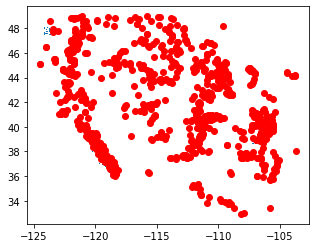

In [268]:
ax = grid_cell_df.plot()
gm_md.plot(ax=ax,c='r')

In [299]:
drop_stations= gm_md.drop(gm_md[(gm_md['station_id'].isin(filter_list))].index)
drop_stations

,station_id,name,elevation_m,latitude,longitude,state,geometry
0,CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,POINT (-120.79200 41.23700)
2,CDEC:ALP,Alpha (Smud),2316.480000,38.804192,-120.215652,California,POINT (-120.21565 38.80419)
4,CDEC:BCH,Beach Meadows,2331.720000,36.126095,-118.293457,California,POINT (-118.29346 36.12609)
5,CDEC:BFL,Big Flat,1554.480000,41.077599,-122.942230,California,POINT (-122.94223 41.07760)
6,CDEC:BGP,Big Pine Creek,2987.040000,37.127815,-118.476967,California,POINT (-118.47697 37.12782)
...,...,...,...,...,...,...,...
758,SNOTEL:992_UT_SNTL,Bear River RS,2675.229492,40.885201,-110.827698,Utah,POINT (-110.82770 40.88520)
759,SNOTEL:994_WA_SNTL,Epa Quinault Open,91.440002,46.483330,-123.966667,Washington,POINT (-123.96667 46.48333)
760,SNOTEL:995_WA_SNTL,Epa Quinault Can,91.440002,46.483330,-123.966667,Washington,POINT (-123.96667 46.48333)
761,SNOTEL:996_WA_SNTL,NWA Heather Mdws,1267.968018,48.849998,-121.666672,Washington,POINT (-121.66667 48.85000)


<AxesSubplot:>

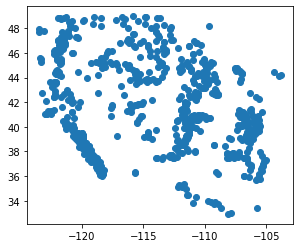

In [280]:
drop_stations.plot()


## Training data

### Ground measures

Below is the SWE values from ground stations for our training dataset. 

In [338]:
gm_train_feat = pd.read_csv("../data/ground_measures_train_features.csv")
gm_train_feat.rename(columns={'Unnamed: 0': "station_id"},inplace=True)
gm_train_feat

,station_id,2013-01-01,2013-01-08,2013-01-15,2013-01-22,2013-01-29,2013-02-05,2013-02-12,2013-02-19,2013-02-26,...,2019-05-28,2019-06-04,2019-06-11,2019-06-18,2019-06-25,2019-12-03,2019-12-10,2019-12-17,2019-12-24,2019-12-31
0,CDEC:ADM,5.90,5.90,6.50,6.50,7.40,7.60,7.40,8.00,8.00,...,NaN,NaN,NaN,NaN,NaN,0.70,1.20,3.40,3.70,3.40
1,CDEC:AGP,17.52,17.54,17.85,17.39,18.03,17.70,17.65,16.66,17.21,...,NaN,NaN,NaN,NaN,NaN,0.00,0.60,0.20,NaN,NaN
2,CDEC:ALP,12.75,13.32,14.26,14.02,13.39,13.25,14.30,13.95,15.73,...,29.52,20.81,8.71,0.30,0.00,5.69,8.04,10.74,12.67,12.57
3,CDEC:BCB,4.30,4.42,4.62,4.53,4.67,4.90,4.90,5.06,5.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CDEC:BCH,2.88,3.00,3.48,3.84,3.96,4.44,5.40,5.16,3.60,...,0.84,0.60,0.36,0.36,0.24,2.88,4.56,4.68,5.04,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,9.00,10.20,10.90,11.10,12.80,14.10,14.40,14.60,17.60,...,0.00,0.00,0.00,0.00,0.00,0.30,0.20,1.60,2.80,3.00
696,SNOTEL:990_WA_SNTL,27.50,29.10,31.50,31.90,33.40,33.90,35.40,36.50,38.80,...,6.00,0.10,0.00,0.00,0.00,1.00,0.90,2.30,8.70,8.60
697,SNOTEL:992_UT_SNTL,4.10,4.10,4.40,4.50,4.80,5.10,5.20,5.30,6.10,...,0.00,0.00,0.00,0.00,0.00,2.00,2.20,3.50,3.60,3.80
698,SNOTEL:998_WA_SNTL,48.40,55.50,61.50,62.20,67.50,70.10,72.90,77.00,83.30,...,53.60,36.10,31.30,8.50,0.00,8.00,9.00,13.20,23.70,25.00


In [278]:
stations_train = list(gm_train_feat['station_id'].values)
len(stations_train)

700

Let's find out if these stations carry any nulls.

<AxesSubplot:>

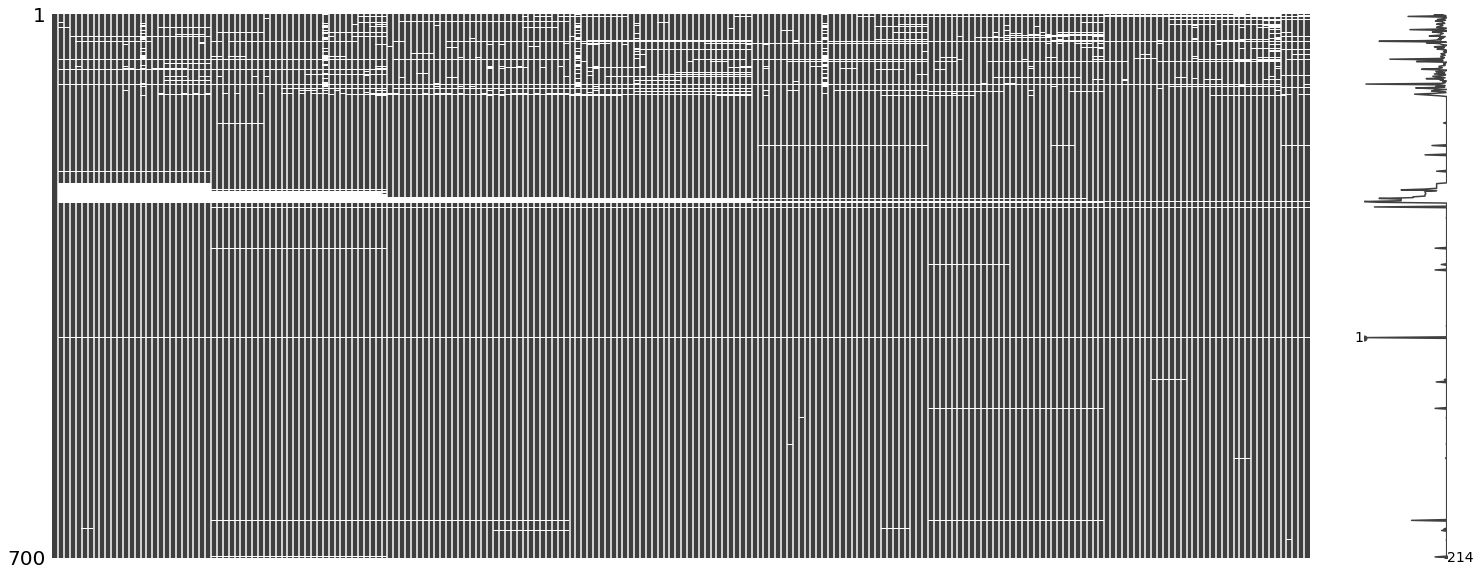

In [325]:
import missingno as msno

msno.matrix(gm_train_feat)

Based on the above heatmap of NaNs, there are a number of stations that have completely null values, and a number of stations that are mostly null values. Let's find out which stations have the most nulls.

In [341]:
# pd.set_option('display.max_columns', None)


In [342]:
# Transpose and set station id as columns 
gm_t=gm_train_feat.T
gm_t.columns = gm_t.iloc[0]
gm_t = gm_t[1:]
gm_t

station_id,CDEC:ADM,CDEC:AGP,CDEC:ALP,CDEC:BCB,CDEC:BCH,CDEC:BFL,CDEC:BGP,CDEC:BIM,CDEC:BKL,CDEC:BLA,CDEC:BLC,CDEC:BLD,CDEC:BLK,CDEC:BLS,CDEC:BMW,CDEC:BNK,CDEC:BSK,CDEC:CDP,CDEC:CHM,CDEC:CHP,CDEC:CRL,CDEC:CSL,CDEC:CSV,CDEC:CWD,CDEC:CWF,CDEC:CXS,CDEC:DAN,CDEC:DDM,CDEC:DPO,CDEC:DSS,CDEC:EBB,CDEC:EP5,CDEC:FDC,CDEC:FLL,CDEC:FRN,CDEC:GEM,CDEC:GIN,CDEC:GKS,CDEC:GNF,CDEC:GNL,CDEC:GRM,CDEC:GRV,CDEC:GRZ,CDEC:HGM,CDEC:HIG,CDEC:HMB,CDEC:HNT,CDEC:HOR,CDEC:HRK,CDEC:HRS,CDEC:HVN,CDEC:HYS,CDEC:IDC,CDEC:IDP,CDEC:INN,CDEC:KTL,CDEC:LBD,CDEC:LVM,CDEC:LVT,CDEC:MDW,CDEC:MED,CDEC:MHP,CDEC:MNT,CDEC:MRL,CDEC:MSK,CDEC:MTM,CDEC:PDS,CDEC:PET,CDEC:PSC,CDEC:PSN,CDEC:QUA,CDEC:RBP,CDEC:RCC,CDEC:RCK,CDEC:RP2,CDEC:RRM,CDEC:RTL,CDEC:SCN,CDEC:SCT,CDEC:SDF,CDEC:SDW,CDEC:SHM,CDEC:SIL,CDEC:SLM,CDEC:SLT,CDEC:SPS,CDEC:SPT,CDEC:SQV,CDEC:SWM,CDEC:TCC,CDEC:TK2,CDEC:TMR,CDEC:TNY,CDEC:TUM,CDEC:UBC,CDEC:UTY,CDEC:VLC,CDEC:VRG,CDEC:VVL,CDEC:WC3,CDEC:WHW,CDEC:WTM,CDEC:WWC,SNOTEL:1000_OR_SNTL,SNOTEL:1005_CO_SNTL,SNOTEL:1009_MT_SNTL,SNOTEL:1010_OR_SNTL,SNOTEL:1011_WA_SNTL,SNOTEL:1012_WA_SNTL,SNOTEL:1013_UT_SNTL,SNOTEL:1014_CO_SNTL,SNOTEL:1015_WY_SNTL,SNOTEL:1016_ID_SNTL,SNOTEL:1017_NM_SNTL,SNOTEL:1030_CO_SNTL,SNOTEL:1031_CO_SNTL,SNOTEL:1032_CO_SNTL,SNOTEL:1033_CO_SNTL,SNOTEL:1034_NM_SNTL,SNOTEL:1039_UT_SNTL,SNOTEL:1040_CO_SNTL,SNOTEL:1043_WA_SNTL,SNOTEL:1044_OR_SNTL,SNOTEL:1045_WY_SNTL,SNOTEL:1046_WY_SNTL,SNOTEL:1048_NM_SNTL,SNOTEL:1050_CA_SNTL,SNOTEL:1051_CA_SNTL,SNOTEL:1052_CA_SNTL,SNOTEL:1053_ID_SNTL,SNOTEL:1054_UT_SNTL,SNOTEL:1058_CO_SNTL,SNOTEL:1061_CO_SNTL,SNOTEL:1065_UT_SNTL,SNOTEL:1066_UT_SNTL,SNOTEL:1067_CA_SNTL,SNOTEL:1068_WA_SNTL,SNOTEL:1077_OR_SNTL,SNOTEL:1079_OR_SNTL,SNOTEL:1082_WY_SNTL,SNOTEL:1084_OR_SNTL,SNOTEL:1085_WA_SNTL,SNOTEL:1098_UT_SNTL,SNOTEL:1099_UT_SNTL,SNOTEL:1100_CO_SNTL,SNOTEL:1101_CO_SNTL,SNOTEL:1104_WA_SNTL,SNOTEL:1105_MT_SNTL,SNOTEL:1107_WA_SNTL,SNOTEL:1109_WA_SNTL,SNOTEL:1110_NV_SNTL,SNOTEL:1111_NV_SNTL,SNOTEL:1113_UT_SNTL,SNOTEL:1114_UT_SNTL,SNOTEL:1115_UT_SNTL,SNOTEL:1119_WY_SNTL,SNOTEL:1120_CO_SNTL,SNOTEL:1121_AZ_SNTL,SNOTEL:1122_CO_SNTL,SNOTEL:1123_CO_SNTL,SNOTEL:1124_CO_SNTL,SNOTEL:1127_AZ_SNTL,SNOTEL:1128_CO_SNTL,SNOTEL:1129_WA_SNTL,SNOTEL:1131_WY_SNTL,SNOTEL:1132_WY_SNTL,SNOTEL:1133_WY_SNTL,SNOTEL:1134_WY_SNTL,SNOTEL:1135_UT_SNTL,SNOTEL:1136_NV_SNTL,SNOTEL:1138_NM_SNTL,SNOTEL:1139_AZ_SNTL,SNOTEL:1140_AZ_SNTL,SNOTEL:1141_CO_SNTL,SNOTEL:1143_AZ_SNTL,SNOTEL:1144_MT_SNTL,SNOTEL:1146_UT_SNTL,SNOTEL:1147_NV_SNTL,SNOTEL:1148_UT_SNTL,SNOTEL:1149_UT_SNTL,SNOTEL:1150_NV_SNTL,SNOTEL:1152_NV_SNTL,SNOTEL:1154_UT_SNTL,SNOTEL:1155_NV_SNTL,SNOTEL:1156_UT_SNTL,SNOTEL:1159_WA_SNTL,SNOTEL:1160_CO_SNTL,SNOTEL:1161_CO_SNTL,SNOTEL:1162_UT_SNTL,SNOTEL:1166_OR_SNTL,SNOTEL:1167_OR_SNTL,SNOTEL:1168_NM_SNTL,SNOTEL:1169_NM_SNTL,SNOTEL:1170_NM_SNTL,SNOTEL:1171_WA_SNTL,SNOTEL:1172_NM_SNTL,SNOTEL:1184_UT_SNTL,SNOTEL:1185_CO_SNTL,SNOTEL:1186_CO_SNTL,SNOTEL:1187_CO_SNTL,SNOTEL:1192_UT_SNTL,SNOTEL:1195_NV_SNTL,SNOTEL:1196_WY_SNTL,SNOTEL:1197_UT_SNTL,SNOTEL:1214_UT_SNTL,SNOTEL:1215_UT_SNTL,SNOTEL:1216_UT_SNTL,SNOTEL:1222_UT_SNTL,SNOTEL:1223_UT_SNTL,SNOTEL:1224_UT_SNTL,SNOTEL:1225_UT_SNTL,SNOTEL:1226_UT_SNTL,SNOTEL:1227_UT_SNTL,SNOTEL:1228_UT_SNTL,SNOTEL:1231_WA_SNTL,SNOTEL:1236_UT_SNTL,SNOTEL:1242_NV_SNTL,SNOTEL:1243_NV_SNTL,SNOTEL:1244_NV_SNTL,SNOTEL:1247_UT_SNTL,SNOTEL:1248_UT_SNTL,SNOTEL:1249_UT_SNTL,SNOTEL:1251_CO_SNTL,SNOTEL:1254_NM_SNTL,SNOTEL:1256_WA_SNTL,SNOTEL:1257_WA_SNTL,SNOTEL:1258_CA_SNTL,SNOTEL:1259_WA_SNTL,SNOTEL:1261_UT_SNTL,SNOTEL:1262_NV_SNTL,SNOTEL:1263_WA_SNTL,SNOTEL:1269_UT_SNTL,SNOTEL:1271_AZ_SNTL,SNOTEL:2029_ID_SNTL,SNOTEL:301_CA_SNTL,SNOTEL:302_OR_SNTL,SNOTEL:303_CO_SNTL,SNOTEL:304_OR_SNTL,SNOTEL:306_ID_SNTL,SNOTEL:308_AZ_SNTL,SNOTEL:311_MT_SNTL,SNOTEL:312_ID_SNTL,SNOTEL:313_MT_SNTL,SNOTEL:316_NM_SNTL,SNOTEL:317_WY_SNTL,SNOTEL:319_ID_SNTL,SNOTEL:320_ID_SNTL,SNOTEL:321_NV_SNTL,SNOTEL:322_CO_SNTL,SNOTEL:324_ID_SNTL,SNOTEL:325_WY_SNTL,SNOTEL:326_WY_SNTL,SNOTEL:327_CO_SNTL,SNOTEL:328_MT_SNTL,SNOTEL:329_UT_SNTL,SNOTEL:330_UT_SNTL,SNOTEL:331_OR_SNTL,SNOTE

In [254]:
gm_t.index = pd.to_datetime(gm_t.index)

In [331]:
gm_t ['SNOTEL:1271_AZ_SNTL'].isna().sum()

87

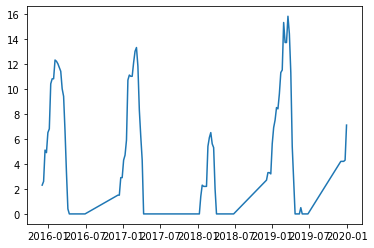

In [332]:
plt.plot(gm_t ['SNOTEL:1271_AZ_SNTL'])

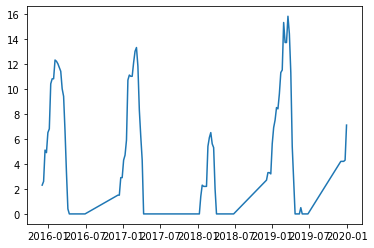

In [333]:
interpolated = gm_t['SNOTEL:1271_AZ_SNTL'].astype(float).interpolate(option='spline')

plt.plot(interpolated)

In [247]:
interpolated.isna().sum()

0

In [320]:
gm_t.isna().sum().sort_values(ascending=False)[mask]*100/213

station_id
CDEC:BCB               46.948357
CDEC:CRL               44.600939
SNOTEL:878_WY_SNTL     42.723005
SNOTEL:1269_UT_SNTL    40.845070
SNOTEL:1271_AZ_SNTL    40.845070
                         ...    
SNOTEL:393_UT_SNTL      0.000000
SNOTEL:392_UT_SNTL      0.000000
SNOTEL:390_UT_SNTL      0.000000
SNOTEL:389_WY_SNTL      0.000000
SNOTEL:999_WA_SNTL      0.000000
Length: 688, dtype: float64

In [327]:
#Look at percentage of null values 
(gm_t.isna().sum().sort_values(ascending=False)[:50])*100/213

station_id
SNOTEL:549_NV_SNTL     100.000000
SNOTEL:1286_MT_SNTL    100.000000
CDEC:SSM                98.122066
SNOTEL:305_CO_SNTL      87.793427
SNOTEL:1287_MT_SNTL     83.568075
CDEC:FRW                82.159624
SNOTEL:1272_NV_SNTL     82.159624
CDEC:LLP                69.014085
SNOTEL:1277_CA_SNTL     55.399061
SNOTEL:1280_UT_SNTL     55.399061
SNOTEL:1252_CO_SNTL     55.399061
SNOTEL:1278_UT_SNTL     55.399061
CDEC:BCB                46.948357
CDEC:CRL                44.600939
SNOTEL:878_WY_SNTL      42.723005
SNOTEL:1269_UT_SNTL     40.845070
SNOTEL:1271_AZ_SNTL     40.845070
CDEC:WHW                38.967136
CDEC:TNY                37.558685
CDEC:MDW                36.619718
CDEC:PSN                30.516432
SNOTEL:1256_WA_SNTL     26.291080
SNOTEL:1263_WA_SNTL     26.291080
SNOTEL:1251_CO_SNTL     26.291080
SNOTEL:1257_WA_SNTL     26.291080
SNOTEL:1261_UT_SNTL     26.291080
SNOTEL:1262_NV_SNTL     26.291080
SNOTEL:1148_UT_SNTL     26.291080
SNOTEL:1258_CA_SNTL     25.821596
SNO

Quite a number of these stations have more than 50% of their data as nulls. Let's drop stations that have more than 60% nulls and impute the other stations will nulls using KNN imputer.

#### Dropping nulls in ground measure stations

In [314]:
len(filter_list)

688

In [343]:
# Create mask for stations more than 60% nulls 
mask = ((gm_t.isna().sum().sort_values(ascending=False))*100/213)<20

#Filter and get the list
filter_list = list((gm_t.isna().sum().sort_values(ascending=False))[mask].index)
filter_list

#Drop the stations in the original dataframe
gm_train_feat = gm_train_feat[(gm_train_feat['station_id'].isin(filter_list))]
gm_train_feat

,station_id,2013-01-01,2013-01-08,2013-01-15,2013-01-22,2013-01-29,2013-02-05,2013-02-12,2013-02-19,2013-02-26,2013-03-05,2013-03-12,2013-03-19,2013-03-26,2013-04-02,2013-04-09,2013-04-16,2013-04-23,2013-04-30,2013-05-07,2013-05-14,2013-05-21,2013-05-28,2013-06-04,2013-06-11,2013-06-18,2013-06-25,2013-12-03,2013-12-10,2013-12-17,2013-12-24,2013-12-31,2014-01-07,2014-01-14,2014-01-21,2014-01-28,2014-02-04,2014-02-11,2014-02-18,2014-02-25,2014-03-04,2014-03-11,2014-03-18,2014-03-25,2014-04-01,2014-04-08,2014-04-15,2014-04-22,2014-04-29,2014-05-06,2014-05-13,2014-05-20,2014-05-27,2014-06-03,2014-06-10,2014-06-17,2014-06-24,2014-12-02,2014-12-09,2014-12-16,2014-12-23,2014-12-30,2015-01-06,2015-01-13,2015-01-20,2015-01-27,2015-02-03,2015-02-10,2015-02-17,2015-02-24,2015-03-03,2015-03-10,2015-03-17,2015-03-24,2015-03-31,2015-04-07,2015-04-14,2015-04-21,2015-04-28,2015-05-05,2015-05-12,2015-05-19,2015-05-26,2015-06-02,2015-06-09,2015-06-16,2015-06-23,2015-06-30,2015-12-01,2015-12-08,2015-12-15,2015-12-22,2015-12-29,2016-01-05,2016-01-12,2016-01-19,2016-01-26,2016-02-02,2016-02-09,2016-02-16,2016-02-23,2016-03-01,2016-03-08,2016-03-15,2016-03-22,2016-03-29,2016-04-05,2016-04-12,2016-04-19,2016-04-26,2016-05-03,2016-05-10,2016-05-17,2016-05-24,2016-05-31,2016-06-07,2016-06-14,2016-06-21,2016-06-28,2016-12-06,2016-12-13,2016-12-20,2016-12-27,2017-01-03,2017-01-10,2017-01-17,2017-01-24,2017-01-31,2017-02-07,2017-02-14,2017-02-21,2017-02-28,2017-03-07,2017-03-14,2017-03-21,2017-03-28,2017-04-04,2017-04-11,2017-04-18,2017-04-25,2017-05-02,2017-05-09,2017-05-16,2017-05-23,2017-05-30,2017-06-06,2017-06-13,2017-06-20,2017-06-27,2017-12-05,2017-12-12,2017-12-19,2017-12-26,2018-01-02,2018-01-09,2018-01-16,2018-01-23,2018-01-30,2018-02-06,2018-02-13,2018-02-20,2018-02-27,2018-03-06,2018-03-13,2018-03-20,2018-03-27,2018-04-03,2018-04-10,2018-04-17,2018-04-24,2018-05-01,2018-05-08,2018-05-15,2018-05-22,2018-05-29,2018-06-05,2018-06-12,2018-06-19,2018-06-26,2018-12-04,2018-12-11,2018-12-18,2018-12-25,2019-01-01,2019-01-08,2019-01-15,2019-01-22,2019-01-29,2019-02-05,2019-02-12,2019-02-19,2019-02-26,2019-03-05,2019-03-12,2019-03-19,2019-03-26,2019-04-02,2019-04-09,2019-04-16,2019-04-23,2019-04-30,2019-05-07,2019-05-14,2019-05-21,2019-05-28,2019-06-04,2019-06-11,2019-06-18,2019-06-25,2019-12-03,2019-12-10,2019-12-17,2019-12-24,2019-12-31
0,CDEC:ADM,5.90,5.90,6.50,6.50,7.40,7.60,7.40,8.00,8.00,8.00,8.50,6.20,4.10,1.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.20,0.40,0.50,0.50,0.50,0.80,0.70,0.20,0.10,1.60,1.00,1.50,0.70,0.60,0.00,0.00,3.60,2.90,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.60,0.00,0.90,1.40,1.80,2.30,2.30,1.60,1.40,0.80,0.60,0.20,0.10,0.20,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0.00,2.70,NaN,5.60,9.30,11.20,11.30,11.90,13.80,15.50,17.20,17.60,17.60,19.00,16.70,15.00,17.60,17.10,17.00,12.20,4.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.20,2.70,3.40,3.70,5.50,8.10,11.20,12.60,13.30,15.40,15.60,17.80,NaN,22.40,21.50,18.20,19.20,17.60,16.70,16.30,13.00,7.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.20,0.40,0.80,1.20,1.30,0.60,0.60,1.70,2.90,2.80,1.70,1.60,3.30,4.50,4.90,6.20,7.30,4.80,0.90,0.80,0.00,0.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.20,2.50,3.10,4.90,4.60,6.30,6.50,10.20,10.90,12.00,14.50,17.00,18.60,20.50,22.60,22.10,21.70,21.30,18.20,15.80,9.80,0.40,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,0.70,1.20,3.40,3.70,3.40
1,CDEC:AGP,17.52,17.54,17.85,17.39,18.03,17.70,17.65,16.66,17.21,16.26,18.00,18.11,17.96,17.94,11.41,5.39,3.82,3.60,1.06,0.74,0.74,0.67,0.35,0.42,0.13,0.01,1.72,4.16,3.99,3.88,5.70,6.44,7.36,7.24,7.72,8.24,9.49,9.29,8.75,13.31,13.24,12.24,11.33,13.21,13.11,10.62,5.83,5.20,0.84,0.51,0.11,0.00,0.0,0.00,0.0,0.00,0.77,3.67,5.31,5.51,5.67,6.02,5.57,5.69,5.79,6.54,9.01,8.71,6.86,7.83,6.99,4.93,3.29,1.58,1.95,1.07,0.34,0.52,0.42,0.52,0.08,0.20,0.10,0.00,0.01,0.00,0.00,2.96,2.79,4.77,5.00,6.80,7.02,8.99,9.89,12.32,15.35,15.25,14.53,16.03,15.

In [ ]:
import missingno as msno

msno.matrix(gm_train_feat)

In [318]:
gm_train_feat.isna().sum().sort_values(ascending=False)

2014-04-15    53
2013-04-09    46
2017-02-28    42
2015-12-08    42
2019-06-25    37
              ..
2016-12-27     4
2017-01-03     4
2016-12-06     3
2019-01-01     3
station_id     0
Length: 214, dtype: int64

#### Imput NaNs with KNearestNeighbors

### Training labels

Below is our ground truth data for each cell grid for each date.

In [129]:
train_labels = pd.read_csv("../data/train_labels.csv")
train_labels = train_labels.melt(id_vars=["cell_id"]).dropna()
train_labels.rename({'variable':'dates'},axis=1,inplace=True)
train_labels

,cell_id,dates,value
43,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-01,12.7
77,018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-01,20.4
85,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-01,37.0
120,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2013-01-01,2.3
121,02cf33c2-c8e2-48b9-bf72-92506e97e251,2013-01-01,8.0
...,...,...,...
2904295,fd4492f2-8aa9-4279-bdc0-73991786943f,2019-12-31,1.3
2904321,fde3221a-9ce3-45a9-857f-bd196b07aa05,2019-12-31,5.6
2904323,fdeb8912-f9d1-445d-aadb-e943534f67fe,2019-12-31,8.8
2904336,fe33672e-7ea7-4c5d-8639-96b2cc7edb0c,2019-12-31,2.9


#### Mapping ground measure to training set cell grids

We want to use the SWE of 15 of the nearest ground stations as model features for our cell grids. We will have to which ground stations are nearest to our cell grid first. For this, we will be using [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) package from scipy.

In [48]:
from scipy.spatial.distance import cdist

mat = cdist(gm_md[['latitude','longitude']],grid_cell_df[['centr_lat','centr_lon']],metric='euclidean')
mat
nn_train_df = pd.DataFrame(mat, index=gm_md['station_id'], columns=grid_cell_df['cell_id']) 
nn_df

cell_id,0003f387-71c4-48f6-b2b0-d853bd4f0aba,000617d8-8c14-43e2-b708-7e3a69fe3cc3,000863e7-21e6-477d-b799-f5675c348627,000ba8d9-d6d5-48da-84a2-1fa54951fae1,00146204-d4e9-4cd8-8f86-d1ef133c5b6d,0017d1c4-64cb-426d-9158-3f6521d2dd22,0020c632-3d5c-4509-b4ee-6b63a89bf2ff,00211c19-7ea8-4f21-a2de-1d6216186a96,0021411f-e7b5-48d7-9d36-abecbc255821,00226e82-e747-4f03-9c5d-3eef8ebe515e,...,ffca2dc2-ed02-4006-82a3-fa093863fa68,ffcc02b0-5185-4f6a-bdfd-1ae1b6c68e99,ffce8731-d78f-4c06-ace2-7029b611f1ba,ffd1aa25-27a5-4b28-abb6-e6577d1575be,ffdc53d2-5565-496a-b849-4fcf33f33a36,ffdfb5a4-91a0-41a9-a4d5-501b04ef6326,ffe43514-2c92-43b6-bd84-d183806aca65,ffeabc13-7c6f-4b63-b043-19c8f15e0345,fff95195-ccc9-40b7-b302-a0d8570c86bc,fffb4d40-5947-4922-9f05-5d8b5a243d84
station_id,,,,,,,,,,,,,,,,,,,,,
CDEC:ADM,224.743623,217.127058,225.194881,225.423187,224.310224,225.364712,224.715383,217.736879,235.718814,226.340494,...,217.564170,217.367638,225.514277,217.867862,224.992198,224.703513,235.790265,225.968026,235.581565,235.725434
CDEC:AGP,221.089700,213.528744,221.537957,221.768273,220.655386,221.708563,221.059801,214.143628,232.090669,222.684952,...,213.978919,213.765301,221.857447,214.274768,221.336609,221.050175,232.160983,222.313637,231.952122,232.093362
CDEC:ALP,222.611029,215.048752,223.059285,223.289602,222.176715,223.229892,222.581130,215.663406,233.611689,224.206282,...,215.498298,215.285481,223.378776,215.794539,222.857938,222.571503,233.682028,223.834966,233.473171,233.614465
CDEC:BCB,220.362267,212.810346,220.810043,221.040679,219.927808,220.980773,220.332103,213.426059,231.367342,221.957256,...,213.262668,213.046242,221.129549,213.557224,220.608909,220.322835,231.437472,221.586125,231.228586,231.369401
CDEC:BCH,219.358380,211.820767,219.805390,220.036536,218.923691,219.976315,219.327794,212.437780,230.369957,220.952947,...,212.276455,212.055625,220.124917,212.568984,219.604596,219.319098,230.439796,220.582112,230.230870,230.371013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SNOTEL:994_WA_SNTL,230.712078,223.035542,231.166491,231.392665,230.279664,231.335497,230.685593,223.639707,241.659200,232.310601,...,223.458083,223.280561,231.485773,223.770510,230.962406,230.671350,241.731883,231.936928,241.523364,241.670079
SNOTEL:995_WA_SNTL,230.712078,223.035542,231.166491,231.392665,230.279664,231.335497,230.685593,223.639707,241.659200,232.310601,...,223.458083,223.280561,231.485773,223.770510,230.962406,230.671350,241.731883,231.936928,241.523364,241.670079
SNOTEL:996_WA_SNTL,230.824890,223.021445,231.286566,231.507746,230.394818,231.453625,230.802477,223.614356,241.708033,232.427011,...,223.415447,223.275276,231.605539,223.744782,231.079245,230.782740,241.783349,232.050597,241.575251,241.728084


In [ ]:
def distance_from(loc1,loc2): 
    dist=hs.haversine(loc1,loc2)
    return round(dist,2)

In [ ]:
from scipy.spatial.distance import cdist

mat = cdist(gm_md[['latitude','longitude']],grid_cell_df[['centr_lat','centr_lon']],metric='euclidean')
mat
nn_train_df = pd.DataFrame(mat, index=gm_md['station_id'], columns=grid_cell_df['cell_id']) 
nn_df

In [218]:
test1 = grid_cell_df[['centr_lat','centr_lon']]

,cell_id,centr_lat,centr_lon
0,0003f387-71c4-48f6-b2b0-d853bd4f0aba,-118.722546,37.077059
1,000617d8-8c14-43e2-b708-7e3a69fe3cc3,-107.080380,37.783264
2,000863e7-21e6-477d-b799-f5675c348627,-119.405266,37.026874
3,000ba8d9-d6d5-48da-84a2-1fa54951fae1,-119.324418,37.434560
4,00146204-d4e9-4cd8-8f86-d1ef133c5b6d,-118.524917,36.660236
...,...,...,...
18125,ffdfb5a4-91a0-41a9-a4d5-501b04ef6326,-118.623732,37.120049
18126,ffe43514-2c92-43b6-bd84-d183806aca65,-123.501584,47.903727
18127,ffeabc13-7c6f-4b63-b043-19c8f15e0345,-119.647811,37.882592
18128,fff95195-ccc9-40b7-b302-a0d8570c86bc,-123.375819,47.734833


In [226]:
gm_md[['latitude','longitude']].iloc[1]

latitude      37.726631
longitude   -119.141731
Name: 1, dtype: float64

In [287]:
distance_from(gm_md[['latitude','longitude']].iloc[1],grid_cell_df[['centr_lat','centr_lon']].iloc[1])

12430.35

Get 20 nearest neighbor and put it in our cell grid dataframe.

In [215]:
nn_df['0003f387-71c4-48f6-b2b0-d853bd4f0aba'].sort_values(ascending=True)[:20]

station_id
SNOTEL:1034_NM_SNTL    208.693331
SNOTEL:1048_NM_SNTL    209.837492
SNOTEL:755_NM_SNTL     209.967223
SNOTEL:854_NM_SNTL     210.261751
SNOTEL:678_NM_SNTL     210.383640
SNOTEL:921_NM_SNTL     210.388766
SNOTEL:922_NM_SNTL     210.418852
SNOTEL:1254_NM_SNTL    210.538547
SNOTEL:491_NM_SNTL     210.580213
SNOTEL:1170_NM_SNTL    210.583914
SNOTEL:757_NM_SNTL     210.677993
SNOTEL:685_CO_SNTL     210.690730
SNOTEL:1168_NM_SNTL    210.796621
SNOTEL:1169_NM_SNTL    210.802287
SNOTEL:715_NM_SNTL     210.805381
SNOTEL:708_NM_SNTL     210.946559
SNOTEL:665_NM_SNTL     210.967548
SNOTEL:857_CO_SNTL     211.037774
SNOTEL:430_CO_SNTL     211.086316
SNOTEL:303_CO_SNTL     211.086862
Name: 0003f387-71c4-48f6-b2b0-d853bd4f0aba, dtype: float64

In [216]:
nn_df['000863e7-21e6-477d-b799-f5675c348627'].sort_values(ascending=True)[:20]

station_id
SNOTEL:1034_NM_SNTL    209.157253
SNOTEL:1048_NM_SNTL    210.297106
SNOTEL:755_NM_SNTL     210.426214
SNOTEL:854_NM_SNTL     210.729959
SNOTEL:678_NM_SNTL     210.851722
SNOTEL:921_NM_SNTL     210.856399
SNOTEL:922_NM_SNTL     210.886626
SNOTEL:1254_NM_SNTL    211.007080
SNOTEL:491_NM_SNTL     211.049066
SNOTEL:1170_NM_SNTL    211.053505
SNOTEL:757_NM_SNTL     211.136751
SNOTEL:685_CO_SNTL     211.165725
SNOTEL:1168_NM_SNTL    211.266271
SNOTEL:1169_NM_SNTL    211.272640
SNOTEL:715_NM_SNTL     211.275417
SNOTEL:708_NM_SNTL     211.413523
SNOTEL:665_NM_SNTL     211.438194
SNOTEL:857_CO_SNTL     211.509007
SNOTEL:430_CO_SNTL     211.557408
SNOTEL:303_CO_SNTL     211.558375
Name: 000863e7-21e6-477d-b799-f5675c348627, dtype: float64

In [208]:
#Helper function

def nn_20(cell_id,df):
    """
    Get 20 nearest neighbor from dataframe and return a list of the stations names.
    """
    station_list = list(df[cell_id].sort_values(ascending=True)[:20].index)
    return station_list
    

In [209]:
#Put the list of nearest neighbors in our cell grid dataframe.

grid_cell_df['nearest_neighb'] = [nn_20(x,nn_df) for x in grid_cell_df['cell_id']]
grid_cell_df.set_index('cell_id')

,coordinates,region,centr_lat,centr_lon,nearest_neighb
cell_id,,,,,
0003f387-71c4-48f6-b2b0-d853bd4f0aba,"[[-118.718953, 37.074192], [-118.718953, 37.08...",sierras,-118.722546,37.077059,"[SNOTEL:1034_NM_SNTL, SNOTEL:1048_NM_SNTL, SNO..."
000617d8-8c14-43e2-b708-7e3a69fe3cc3,"[[-107.076787, 37.780424], [-107.076787, 37.78...",central rockies,-107.080380,37.783264,"[SNOTEL:1034_NM_SNTL, SNOTEL:1048_NM_SNTL, SNO..."
000863e7-21e6-477d-b799-f5675c348627,"[[-119.401673, 37.024005], [-119.401673, 37.03...",other,-119.405266,37.026874,"[SNOTEL:1034_NM_SNTL, SNOTEL:1048_NM_SNTL, SNO..."
000ba8d9-d6d5-48da-84a2-1fa54951fae1,"[[-119.320824, 37.431707], [-119.320824, 37.43...",sierras,-119.324418,37.434560,"[SNOTEL:1034_NM_SNTL, SNOTEL:1048_NM_SNTL, SNO..."
00146204-d4e9-4cd8-8f86-d1ef133c5b6d,"[[-118.521324, 36.657353], [-118.521324, 36.66...",sierras,-118.524917,36.660236,"[SNOTEL:1034_NM_SNTL, SNOTEL:1048_NM_SNTL, SNO..."
...,...,...,...,...,...
ffdfb5a4-91a0-41a9-a4d5-501b04ef6326,"[[-118.620138, 37.117184], [-118.620138, 37.12...",sierras,-118.623732,37.120049,"[SNOTEL:1034_NM_SNTL, SNOTEL:1048_NM_SNTL, SNO..."
ffe43514-2c92-43b6-bd84-d183806aca65,"[[-123.49799, 47.901318], [-123.49799, 47.9073...",other,-123.501584,47.903727,"[SNOTEL:1034_NM_SNTL, SNOTEL:1048_NM_SNTL, SNO..."
ffeabc13-7c6f-4b63-b043-19c8f15e0345,"[[-119.644218, 37.879756], [-119.644218, 37.88...",sierras,-119.647811,37.882592,"[SNOTEL:1034_NM_SNTL, SNOTEL:1048_NM_SNTL, SNO..."


In [211]:
grid_cell_df['nearest_neighb'].explode().unique()

array(['SNOTEL:1034_NM_SNTL', 'SNOTEL:1048_NM_SNTL', 'SNOTEL:755_NM_SNTL',
       'SNOTEL:854_NM_SNTL', 'SNOTEL:678_NM_SNTL', 'SNOTEL:921_NM_SNTL',
       'SNOTEL:922_NM_SNTL', 'SNOTEL:1254_NM_SNTL', 'SNOTEL:491_NM_SNTL',
       'SNOTEL:1170_NM_SNTL', 'SNOTEL:757_NM_SNTL', 'SNOTEL:685_CO_SNTL',
       'SNOTEL:1168_NM_SNTL', 'SNOTEL:1169_NM_SNTL', 'SNOTEL:715_NM_SNTL',
       'SNOTEL:708_NM_SNTL', 'SNOTEL:665_NM_SNTL', 'SNOTEL:857_CO_SNTL',
       'SNOTEL:430_CO_SNTL', 'SNOTEL:303_CO_SNTL', 'SNOTEL:486_NM_SNTL'],
      dtype=object)

#### Add nearest neighboring stations to training set dataframe

Add neighbors values to our dataframe.

In [130]:
#Function to help us pull nearest neighbor list

def get_neighb_list(df_idx,label_df, grid_df):
    """
    Get the neareset neighbor list for the row
    """
    cell_id = label_df['cell_id'].iloc[df_idx]
    nn_list = grid_df[grid_df['cell_id'] == cell_id]['nearest_neighb'].values[0]

    return nn_list

def get_gm_value(df_idx, station_idx, gm_df,label_df):
    value = gm_df[gm_df['station_id'] == nn_list[station_idx]][label_df['dates'].iloc[df_idx]].values[0]
    return value

In [131]:
get_gm_value(0,0,gm_train_feat,train_labels)

6.6

In [132]:
get_neighb_list(0,train_labels,grid_cell_df)

['SNOTEL:1034_NM_SNTL',
 'SNOTEL:1048_NM_SNTL',
 'SNOTEL:755_NM_SNTL',
 'SNOTEL:854_NM_SNTL',
 'SNOTEL:678_NM_SNTL',
 'SNOTEL:921_NM_SNTL',
 'SNOTEL:922_NM_SNTL',
 'SNOTEL:1254_NM_SNTL',
 'SNOTEL:491_NM_SNTL',
 'SNOTEL:1170_NM_SNTL',
 'SNOTEL:685_CO_SNTL',
 'SNOTEL:757_NM_SNTL',
 'SNOTEL:1168_NM_SNTL',
 'SNOTEL:1169_NM_SNTL',
 'SNOTEL:715_NM_SNTL',
 'SNOTEL:708_NM_SNTL',
 'SNOTEL:665_NM_SNTL',
 'SNOTEL:857_CO_SNTL',
 'SNOTEL:303_CO_SNTL',
 'SNOTEL:430_CO_SNTL']

In [137]:
for k in range (15,20):
    neighbor=[]
    for i in range(0,len(train_labels)):
        nn_list = get_neighb_list(i,train_labels,grid_cell_df)
        try:
            value = get_gm_value(i,k,gm_train_feat,train_labels)
        except:
            value = np.NaN
        neighbor.append(value)
    col_name = f'neighbor_{k+1}'
    train_labels[col_name] = neighbor

In [139]:
train_labels

,cell_id,dates,value,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_6,neighbor_7,...,neighbor_11,neighbor_12,neighbor_13,neighbor_14,neighbor_15,neighbor_16,neighbor_17,neighbor_18,neighbor_19,neighbor_20
43,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-01,12.7,6.6,1.6,2.0,3.2,NaN,1.5,4.5,...,NaN,3.2,5.9,2.4,2.3,2.0,1.8,2.7,1.9,5.0
77,018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-01,20.4,6.6,1.6,2.0,3.2,NaN,1.5,4.5,...,NaN,3.2,5.9,2.4,2.3,2.0,1.8,2.7,5.0,1.9
85,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-01,37.0,6.6,1.6,2.0,3.2,NaN,1.5,4.5,...,3.2,NaN,5.9,2.4,2.3,2.0,1.8,2.7,5.0,1.9
120,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2013-01-01,2.3,6.6,1.6,2.0,3.2,NaN,1.5,4.5,...,4.1,2.4,2.3,5.9,1.8,3.2,2.7,2.0,1.9,5.0
121,02cf33c2-c8e2-48b9-bf72-92506e97e251,2013-01-01,8.0,6.6,1.6,2.0,3.2,NaN,1.5,4.5,...,4.1,2.4,5.9,2.3,3.2,1.8,2.7,2.0,1.9,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2904295,fd4492f2-8aa9-4279-bdc0-73991786943f,2019-12-31,1.3,4.1,2.7,1.3,8.0,NaN,3.3,9.0,...,5.6,4.9,10.2,5.0,6.7,4.9,5.5,4.9,2.5,8.1
2904321,fde3221a-9ce3-45a9-857f-bd196b07aa05,2019-12-31,5.6,4.1,2.7,1.3,8.0,NaN,3.3,9.0,...,5.6,4.9,10.2,5.0,6.7,4.9,4.9,5.5,2.5,8.1
2904323,fdeb8912-f9d1-445d-aadb-e943534f67fe,2019-12-31,8.8,4.1,2.7,1.3,8.0,NaN,3.3,9.0,...,NaN,4.9,10.2,5.0,6.7,4.9,4.9,5.5,2.5,8.1
2904336,fe33672e-7ea7-4c5d-8639-96b2cc7edb0c,2019-12-31,2.9,4.1,2.7,1.3,8.0,NaN,3.3,9.0,...,NaN,6.7,10.2,4.9,5.0,4.9,4.9,5.5,2.5,8.1


In [145]:
train_labels[train_labels['cell_id'] == '00c4db22-a423-41a4-ada6-a8b1b04153a4']

,cell_id,dates,value,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_6,neighbor_7,...,neighbor_11,neighbor_12,neighbor_13,neighbor_14,neighbor_15,neighbor_16,neighbor_17,neighbor_18,neighbor_19,neighbor_20
43,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-01,12.7,6.6,1.6,2.0,3.2,NaN,1.5,4.5,...,NaN,3.2,5.9,2.4,2.3,2.0,1.8,2.7,1.9,5.0
10921,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-08,13.2,6.8,1.9,2.1,3.3,NaN,1.5,4.6,...,NaN,3.2,6.1,2.4,2.3,2.1,1.8,2.8,2.6,5.2
21799,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-15,13.8,6.8,1.8,2.0,3.4,NaN,1.6,4.7,...,NaN,3.1,5.9,2.6,2.6,2.1,1.7,3.0,2.6,5.5
32677,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-22,13.9,6.9,1.8,2.2,3.5,NaN,1.6,4.9,...,NaN,3.3,6.1,2.6,2.8,2.3,1.8,3.2,2.8,5.5
43555,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-29,13.9,7.7,1.5,1.7,4.6,NaN,2.1,6.0,...,NaN,4.1,8.6,3.3,3.9,3.3,1.9,3.8,2.8,6.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2850079,00c4db22-a423-41a4-ada6-a8b1b04153a4,2019-12-03,5.6,3.7,2.6,1.5,5.3,NaN,2.2,5.4,...,NaN,3.8,6.0,3.2,3.3,2.4,3.5,2.7,1.0,4.5
2860957,00c4db22-a423-41a4-ada6-a8b1b04153a4,2019-12-10,5.0,3.8,2.0,0.4,6.6,NaN,2.5,7.2,...,NaN,4.6,7.7,3.5,3.8,3.6,4.0,3.2,0.7,5.7
2871835,00c4db22-a423-41a4-ada6-a8b1b04153a4,2019-12-17,2.6,3.9,1.6,0.0,6.7,NaN,2.4,7.2,...,NaN,4.5,8.4,4.3,4.4,3.6,4.3,4.7,1.6,6.9
2882713,00c4db22-a423-41a4-ada6-a8b1b04153a4,2019-12-24,5.6,3.5,1.5,0.0,6.8,NaN,2.3,7.2,...,NaN,4.7,8.6,4.3,4.6,3.7,4.5,4.9,1.7,7.1


Delete the stations that have tons of missing data. And recalculate nearest neighbors.

In [140]:
train_labels.isna().sum()

cell_id            0
dates              0
value              0
neighbor_1     41032
neighbor_2     41032
neighbor_3     41032
neighbor_4     41032
neighbor_5     91490
neighbor_6     41032
neighbor_7     41032
neighbor_8     49342
neighbor_9     51432
neighbor_10    44014
neighbor_11    69741
neighbor_12    46625
neighbor_13    41032
neighbor_14    41032
neighbor_15    41032
neighbor_16    41032
neighbor_17    41032
neighbor_18    41032
neighbor_19    41032
neighbor_20    41032
dtype: int64

In [92]:
train_labels['neighbor_1'] = neighbor_1
train_labels['neighbor_1'].value_counts()

0.0     25634
0.2      1423
0.3      1067
1.4       859
0.7       858
        ...  
9.5       212
13.2      212
13.5      212
5.5       212
4.1       212
Name: neighbor_1, Length: 68, dtype: int64

In [109]:
train_labels['neighbor_2'] = neighbor_2
train_labels['neighbor_2'].value_counts()

0.0    31552
0.5     1497
1.3     1287
2.6     1077
0.2      863
1.9      860
2.8      650
1.2      647
1.6      644
1.5      644
0.6      644
2.7      643
1.8      642
0.8      642
0.3      641
2.5      434
3.3      434
0.9      434
2.2      433
2.4      432
2.0      430
3.4      429
1.7      429
5.2      428
5.0      427
1.4      216
0.7      216
1.1      215
0.4      215
2.3      215
5.8      214
5.6      214
3.7      214
4.8      214
4.2      214
3.8      214
4.3      214
3.1      214
0.1      214
4.1      212
Name: neighbor_2, dtype: int64

In [120]:
train_labels[train_labels['neighbor_1'].isna()]['dates'].unique()

array(['2013-04-03', '2013-04-29', '2013-05-03', '2013-05-25',
       '2013-06-01', '2013-06-08', '2016-02-08', '2016-03-26',
       '2016-04-01', '2016-04-03', '2016-04-04', '2016-04-07',
       '2016-04-16', '2016-05-09', '2016-05-27', '2016-06-26',
       '2017-01-28', '2017-01-29', '2018-03-04', '2018-03-30',
       '2018-03-31', '2018-04-22', '2018-04-23', '2018-04-25',
       '2018-04-26', '2018-05-24', '2018-05-28', '2018-06-01',
       '2018-06-02', '2019-03-09', '2019-03-15', '2019-03-16',
       '2019-03-17', '2019-03-24', '2019-03-25', '2019-03-29',
       '2019-04-07', '2019-04-08', '2019-04-17', '2019-04-18',
       '2019-04-19', '2019-04-21', '2019-04-27', '2019-04-28',
       '2019-05-01', '2019-05-02', '2019-05-03', '2019-06-05',
       '2019-06-08', '2019-06-09', '2019-06-10', '2019-06-13',
       '2019-06-14', '2019-06-24'], dtype=object)

In [119]:
train_labels[train_labels['neighbor_1'].isna()]['dates'].unique() == train_labels[train_labels['neighbor_2'].isna()]['dates'].unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [141]:
train_labels[train_labels['dates'] == '2013-02-26']

,cell_id,dates,value,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_6,neighbor_7,...,neighbor_11,neighbor_12,neighbor_13,neighbor_14,neighbor_15,neighbor_16,neighbor_17,neighbor_18,neighbor_19,neighbor_20
87067,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-02-26,17.4,8.7,2.4,2.1,6.8,NaN,2.8,8.7,...,NaN,5.5,12.5,5.0,6.1,4.5,4.3,6.5,5.1,8.5
87101,018cf1a1-f945-4097-9c47-0c4690538bb5,2013-02-26,25.2,8.7,2.4,2.1,6.8,NaN,2.8,8.7,...,NaN,5.5,12.5,5.0,6.1,4.5,4.3,6.5,8.5,5.1
87109,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-02-26,42.1,8.7,2.4,2.1,6.8,NaN,2.8,8.7,...,5.5,NaN,12.5,5.0,6.1,4.5,4.3,6.5,8.5,5.1
87144,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2013-02-26,5.2,8.7,2.4,2.1,6.8,NaN,2.8,8.7,...,7.9,5.0,6.1,12.5,4.3,5.5,6.5,4.5,5.1,8.5
87145,02cf33c2-c8e2-48b9-bf72-92506e97e251,2013-02-26,15.1,8.7,2.4,2.1,6.8,NaN,2.8,8.7,...,7.9,5.0,12.5,6.1,5.5,4.3,6.5,4.5,5.1,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97771,fd4492f2-8aa9-4279-bdc0-73991786943f,2013-02-26,1.6,8.7,2.4,2.1,6.8,NaN,2.8,8.7,...,7.9,5.0,12.5,6.1,5.5,4.3,6.5,4.5,5.1,8.5
97797,fde3221a-9ce3-45a9-857f-bd196b07aa05,2013-02-26,4.5,8.7,2.4,2.1,6.8,NaN,2.8,8.7,...,7.9,5.0,12.5,6.1,5.5,4.3,4.5,6.5,5.1,8.5
97799,fdeb8912-f9d1-445d-aadb-e943534f67fe,2013-02-26,8.5,8.7,2.4,2.1,6.8,NaN,2.8,8.7,...,NaN,5.0,12.5,6.1,5.5,4.3,4.5,6.5,5.1,8.5
97812,fe33672e-7ea7-4c5d-8639-96b2cc7edb0c,2013-02-26,25.5,8.7,2.4,2.1,6.8,NaN,2.8,8.7,...,NaN,5.5,12.5,5.0,6.1,4.5,4.3,6.5,5.1,8.5


In [142]:
train_labels[train_labels['dates'] == '2013-02-19']

,cell_id,dates,value,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_6,neighbor_7,...,neighbor_11,neighbor_12,neighbor_13,neighbor_14,neighbor_15,neighbor_16,neighbor_17,neighbor_18,neighbor_19,neighbor_20
76189,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-02-19,15.6,8.3,1.9,1.7,5.4,NaN,2.3,6.9,...,NaN,4.4,10.1,3.7,4.7,3.7,3.4,5.4,4.0,7.3
76223,018cf1a1-f945-4097-9c47-0c4690538bb5,2013-02-19,24.6,8.3,1.9,1.7,5.4,NaN,2.3,6.9,...,NaN,4.4,10.1,3.7,4.7,3.7,3.4,5.4,7.3,4.0
76231,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-02-19,40.9,8.3,1.9,1.7,5.4,NaN,2.3,6.9,...,4.4,NaN,10.1,3.7,4.7,3.7,3.4,5.4,7.3,4.0
76266,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2013-02-19,4.7,8.3,1.9,1.7,5.4,NaN,2.3,6.9,...,6.8,3.7,4.7,10.1,3.4,4.4,5.4,3.7,4.0,7.3
76267,02cf33c2-c8e2-48b9-bf72-92506e97e251,2013-02-19,14.2,8.3,1.9,1.7,5.4,NaN,2.3,6.9,...,6.8,3.7,10.1,4.7,4.4,3.4,5.4,3.7,4.0,7.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86893,fd4492f2-8aa9-4279-bdc0-73991786943f,2013-02-19,0.3,8.3,1.9,1.7,5.4,NaN,2.3,6.9,...,6.8,3.7,10.1,4.7,4.4,3.4,5.4,3.7,4.0,7.3
86919,fde3221a-9ce3-45a9-857f-bd196b07aa05,2013-02-19,3.8,8.3,1.9,1.7,5.4,NaN,2.3,6.9,...,6.8,3.7,10.1,4.7,4.4,3.4,3.7,5.4,4.0,7.3
86921,fdeb8912-f9d1-445d-aadb-e943534f67fe,2013-02-19,8.0,8.3,1.9,1.7,5.4,NaN,2.3,6.9,...,NaN,3.7,10.1,4.7,4.4,3.4,3.7,5.4,4.0,7.3
86934,fe33672e-7ea7-4c5d-8639-96b2cc7edb0c,2013-02-19,22.1,8.3,1.9,1.7,5.4,NaN,2.3,6.9,...,NaN,4.4,10.1,3.7,4.7,3.7,3.4,5.4,4.0,7.3


In [123]:
train_labels['dates'].unique()

array(['2013-01-01', '2013-01-08', '2013-01-15', '2013-01-22',
       '2013-01-29', '2013-02-05', '2013-02-12', '2013-02-19',
       '2013-02-26', '2013-03-05', '2013-03-12', '2013-03-19',
       '2013-03-26', '2013-04-02', '2013-04-03', '2013-04-09',
       '2013-04-16', '2013-04-23', '2013-04-29', '2013-04-30',
       '2013-05-03', '2013-05-07', '2013-05-14', '2013-05-21',
       '2013-05-25', '2013-05-28', '2013-06-01', '2013-06-04',
       '2013-06-08', '2013-06-11', '2013-06-18', '2013-06-25',
       '2013-12-03', '2013-12-10', '2013-12-17', '2013-12-24',
       '2013-12-31', '2014-01-07', '2014-01-14', '2014-01-21',
       '2014-01-28', '2014-02-04', '2014-02-11', '2014-02-18',
       '2014-02-25', '2014-03-04', '2014-03-11', '2014-03-18',
       '2014-03-25', '2014-04-01', '2014-04-08', '2014-04-15',
       '2014-04-22', '2014-04-29', '2014-05-06', '2014-05-13',
       '2014-05-20', '2014-05-27', '2014-06-03', '2014-06-10',
       '2014-06-17', '2014-06-24', '2014-12-02', '2014-

The dataset below is the ground truth data for our testing data. This will be reserved to test our model performance on unseen data.

In [95]:
train_labels

,cell_id,dates,value,neighbor_1
43,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-01,12.7,6.6
77,018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-01,20.4,6.6
85,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-01,37.0,6.6
120,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2013-01-01,2.3,6.6
121,02cf33c2-c8e2-48b9-bf72-92506e97e251,2013-01-01,8.0,6.6
...,...,...,...,...
2904295,fd4492f2-8aa9-4279-bdc0-73991786943f,2019-12-31,1.3,4.1
2904321,fde3221a-9ce3-45a9-857f-bd196b07aa05,2019-12-31,5.6,4.1
2904323,fdeb8912-f9d1-445d-aadb-e943534f67fe,2019-12-31,8.8,4.1
2904336,fe33672e-7ea7-4c5d-8639-96b2cc7edb0c,2019-12-31,2.9,4.1


In [90]:
train_labels[train_labels['dates'] == '2013-04-03']

,cell_id,dates,value
152344,00ef834b-a1de-4305-b7ef-0800961c7fa2,2013-04-03,28.6
152357,01438219-bc42-47bb-8a4f-d50d4c8bcfed,2013-04-03,31.6
152424,02fa9f4d-a454-4e73-8aea-4d19c4ee3e37,2013-04-03,28.7
152446,03968d16-5231-4140-b602-61356a1bd393,2013-04-03,15.2
152474,04149267-2eeb-4910-8360-f76b2df2ad8d,2013-04-03,23.6
...,...,...,...
163081,fe346307-540b-45df-bfa8-4bc42ed80a79,2013-04-03,23.4
163085,fe4f5a7c-93b9-4302-b14d-7703caeedec8,2013-04-03,14.0
163107,fec9cc1e-b0a0-46c4-9d5d-8d057af081ac,2013-04-03,11.8
163128,ff3fa88b-294e-4e25-9285-a8a8d6e1591f,2013-04-03,10.5


## Testing Data

### Ground measures

Below is the SWE values from ground stations for our testing dataset.

In [176]:
gm_test_feat = pd.read_csv("../data/ground_measures_test_features.csv")
gm_test_feat.rename(columns={'Unnamed: 0': "station_id"},inplace=True)
gm_test_feat

,station_id,2020-01-07,2020-01-14,2020-01-21,2020-01-28,2020-02-04,2020-02-11,2020-02-18,2020-02-25,2020-03-03,...,2021-04-27,2021-05-04,2021-05-11,2021-05-18,2021-05-25,2021-06-01,2021-06-08,2021-06-15,2021-06-22,2021-06-29
0,CDEC:ADM,4.50,5.50,7.30,8.30,8.10,8.20,9.30,8.50,7.90,...,0.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CDEC:AGP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CDEC:ALP,12.72,13.78,17.12,18.07,18.17,18.38,17.71,16.05,14.62,...,3.34,0.31,0.02,0.00,0.13,0.01,0.00,0.00,0.00,0.00
3,CDEC:BCB,12.20,12.20,13.30,13.35,12.85,12.72,12.72,12.80,13.16,...,15.44,11.94,5.91,1.10,0.86,1.04,1.12,1.04,1.17,1.25
4,CDEC:BCH,6.60,5.76,5.16,7.68,4.68,1.32,0.84,0.84,0.24,...,0.12,0.24,0.24,0.24,0.12,0.24,0.12,0.24,0.24,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,6.80,12.50,13.10,14.40,16.30,19.10,19.80,19.80,19.70,...,6.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
696,SNOTEL:990_WA_SNTL,13.80,17.00,20.30,24.90,26.70,29.40,29.80,31.10,32.60,...,41.20,38.10,35.90,32.10,28.50,23.20,16.70,10.60,0.90,0.00
697,SNOTEL:992_UT_SNTL,4.40,5.00,5.80,6.20,6.30,6.80,7.20,7.40,7.80,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
698,SNOTEL:998_WA_SNTL,37.90,47.00,51.80,61.90,69.00,73.40,77.30,81.40,83.60,...,96.00,95.10,95.50,94.20,94.20,NaN,75.10,70.40,58.70,35.10


In [177]:
# Transpose and set station id as columns 
gm_test_t=gm_test_feat.T
gm_test_t.columns = gm_test_t.iloc[0]
gm_test_t = gm_t[1:]
gm_test_t

station_id,CDEC:ADM,CDEC:AGP,CDEC:ALP,CDEC:BCB,CDEC:BCH,CDEC:BFL,CDEC:BGP,CDEC:BIM,CDEC:BKL,CDEC:BLA,...,SNOTEL:978_ID_SNTL,SNOTEL:981_MT_SNTL,SNOTEL:982_WY_SNTL,SNOTEL:984_WA_SNTL,SNOTEL:988_ID_SNTL,SNOTEL:989_ID_SNTL,SNOTEL:990_WA_SNTL,SNOTEL:992_UT_SNTL,SNOTEL:998_WA_SNTL,SNOTEL:999_WA_SNTL
2013-01-08,5.9,17.54,13.32,4.42,3.0,7.92,7.28,19.32,17.04,5.64,...,6.6,1.2,1.6,4.3,20.0,10.2,29.1,4.1,55.5,37.5
2013-01-15,6.5,17.85,14.26,4.62,3.48,8.76,7.79,20.16,18.72,7.32,...,7.7,1.8,1.5,5.1,21.7,10.9,31.5,4.4,61.5,40.8
2013-01-22,6.5,17.39,14.02,4.53,3.84,9.0,7.8,20.28,19.2,7.56,...,8.0,1.9,2.0,5.1,21.9,11.1,31.9,4.5,62.2,42.5
2013-01-29,7.4,18.03,13.39,4.67,3.96,10.44,8.35,20.52,19.08,8.28,...,9.7,2.3,2.1,6.4,23.5,12.8,33.4,4.8,67.5,47.5
2013-02-05,7.6,17.7,13.25,4.9,4.44,10.8,8.12,20.16,20.16,9.6,...,11.1,2.4,2.9,7.2,23.8,14.1,33.9,5.1,70.1,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-03,0.7,0.0,5.69,NaN,2.88,3.0,NaN,NaN,6.72,0.0,...,1.5,1.4,2.5,1.4,5.9,0.3,1.0,2.0,8.0,1.6
2019-12-10,1.2,0.6,8.04,NaN,4.56,3.36,NaN,NaN,5.88,0.12,...,2.7,1.7,2.7,1.6,7.7,0.2,0.9,2.2,9.0,0.2
2019-12-17,3.4,0.2,10.74,NaN,4.68,4.56,NaN,NaN,6.12,0.72,...,4.4,1.7,2.7,2.6,9.0,1.6,2.3,3.5,13.2,3.5
2019-12-24,3.7,NaN,12.67,NaN,5.04,5.04,NaN,NaN,10.56,0.36,...,5.0,1.6,2.5,2.3,14.5,2.8,8.7,3.6,23.7,8.4


In [178]:
#Look at percentage of null values 
(gm_test_t.isna().sum().sort_values(ascending=False)[:50])*100/213

station_id
SNOTEL:1286_MT_SNTL    99.530516
SNOTEL:549_NV_SNTL     99.530516
CDEC:SSM               97.652582
SNOTEL:305_CO_SNTL     87.793427
SNOTEL:1287_MT_SNTL    83.098592
CDEC:FRW               82.159624
SNOTEL:1272_NV_SNTL    81.690141
CDEC:LLP               68.544601
SNOTEL:1277_CA_SNTL    54.929577
SNOTEL:1252_CO_SNTL    54.929577
SNOTEL:1280_UT_SNTL    54.929577
SNOTEL:1278_UT_SNTL    54.929577
CDEC:BCB               46.948357
CDEC:CRL               44.600939
SNOTEL:878_WY_SNTL     42.723005
SNOTEL:1269_UT_SNTL    40.375587
SNOTEL:1271_AZ_SNTL    40.375587
CDEC:WHW               38.967136
CDEC:TNY               37.558685
CDEC:MDW               36.619718
CDEC:PSN               30.046948
SNOTEL:1262_NV_SNTL    25.821596
SNOTEL:1261_UT_SNTL    25.821596
SNOTEL:1263_WA_SNTL    25.821596
SNOTEL:1251_CO_SNTL    25.821596
SNOTEL:1148_UT_SNTL    25.821596
SNOTEL:1256_WA_SNTL    25.821596
SNOTEL:1257_WA_SNTL    25.821596
SNOTEL:1258_CA_SNTL    25.352113
CDEC:SHM               24.882629

The dataset below is the ground truth data for our testing data. This will be reserved to test our model performance on unseen data.

In [53]:
test_labels = pd.read_csv("../data/labels_2020_2021.csv")
test_labels = test_labels.melt(id_vars=["cell_id"]).dropna()
test_labels


,cell_id,variable,value
29,00c4db22-a423-41a4-ada6-a8b1b04153a4,2020-01-07,8.0
64,018cf1a1-f945-4097-9c47-0c4690538bb5,2020-01-07,11.4
68,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2020-01-07,18.5
93,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2020-01-07,3.9
95,02cf33c2-c8e2-48b9-bf72-92506e97e251,2020-01-07,13.0
...,...,...,...
516655,fd4492f2-8aa9-4279-bdc0-73991786943f,2021-06-29,0.0
516678,fde3221a-9ce3-45a9-857f-bd196b07aa05,2021-06-29,0.0
516680,fdeb8912-f9d1-445d-aadb-e943534f67fe,2021-06-29,0.0
516693,fe33672e-7ea7-4c5d-8639-96b2cc7edb0c,2021-06-29,0.0


## MODIS data

### Helper Functions

In [ ]:
from gcloud import storage


def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(source_blob_name)

    blob.download_to_filename(destination_file_name)

    print('Blob {} downloaded to {}.'.format(
        source_blob_name,
        destination_file_name))
download_blob("datset","actions", "dataset")

In [ ]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'snow-water-equivalent'
# !gcloud config set project {project_id}
project_name = 'Snow-Water-Equivalent'
bucket_name = 'modis-swe'

fs = gcsfs.GCSFileSystem(projectstring=project_id)
fs.ls(bucket_name)

In [ ]:
import requests

authCode = YOUR_AUTH_CODE
auth = "Bearer " + authCode
myHeaders = {"Authorization": auth}
r = requests.get('https://www.googleapis.com/storage/v1/b/BUCKET_NAME/o/OBJECT_NAME', headers=myHeaders)

print r.text
print r.status_code

These helper functions are from a notebook example provided by [DrivenData](https://www.drivendata.org/competitions/86/competition-reclamation-snow-water-dev/page/417/) [here](https://nbviewer.org/github/microsoft/AIforEarthDataSets/blob/main/data/modis.ipynb).

In [101]:
import tempfile
import wget
import numpy as np
import matplotlib.pyplot as plt
import os

from azure.storage.blob import ContainerClient

ModuleNotFoundError: No module named 'azure'

In [98]:
def lat_lon_to_modis_tile(lat,lon):
    """
    Get the modis tile indices (h,v) for a given lat/lon
    
    https://www.earthdatascience.org/tutorials/convert-modis-tile-to-lat-lon/
    """
    
    found_matching_tile = False
    i = 0
    while(not found_matching_tile):
        found_matching_tile = lat >= modis_tile_extents[i, 4] \
        and lat <= modis_tile_extents[i, 5] \
        and lon >= modis_tile_extents[i, 2] and lon <= modis_tile_extents[i, 3]
        i += 1
        
    v = int(modis_tile_extents[i-1, 0])
    h = int(modis_tile_extents[i-1, 1])
    
    return h,v


def list_blobs_in_folder(container_name,folder_name):
    """
    List all blobs in a virtual folder in an Azure blob container
    """
    
    files = []
    generator = modis_container_client.list_blobs(name_starts_with=folder_name)
    for blob in generator:
        files.append(blob.name)
    return files
        
    
def list_hdf_blobs_in_folder(container_name,folder_name):
    """"
    List .hdf files in a folder
    """
    
    files = list_blobs_in_folder(container_name,folder_name)
    files = [fn for fn in files if fn.endswith('.hdf')]
    return files   